## Creating Structured Data

In [1]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [56]:
# RESULTS_DIR = 'runs/results_24_6_18'
# JAC_RESULTS_DIR = 'runs/results_24_6_18'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_no_semstr'
# EVAL_CONFIG = 'eval.config.json'

# llm_costs = {
#     "completion_tokens": 15/1e6,
#     "prompt_tokens":5/1e6,
# }

In [57]:
# RESULTS_DIR = 'runs/results_24_6_18_no_semstr'
# JAC_RESULTS_DIR = 'runs/results_24_6_18_no_semstr'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_no_semstr'
# EVAL_CONFIG = 'eval.config.nosemstr.json'

# llm_costs = {
#     "completion_tokens": 15/1e6,
#     "prompt_tokens":5/1e6,
# }

In [58]:
# RESULTS_DIR = 'runs/results_24_6_18_gpt_4'
# JAC_RESULTS_DIR = 'runs/results_24_6_18_gpt_4'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_no_semstr'
# EVAL_CONFIG = 'eval.config.json'

# llm_costs = {
#     "completion_tokens": 60/1e6,
#     "prompt_tokens":30/1e6,
# }

In [59]:
# RESULTS_DIR = 'runs/results_24_6_18_gpt_4_no_semstr'
# JAC_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_no_semstr'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_no_semstr'
# EVAL_CONFIG = 'eval.config.nosemstr.json'

# llm_costs = {
#     "completion_tokens": 60/1e6,
#     "prompt_tokens":30/1e6,
# }

In [75]:
# RESULTS_DIR = 'runs/results_24_6_18_gpt_35_turbo'
# JAC_RESULTS_DIR = 'runs/results_24_6_18_gpt_35_turbo'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_gpt_35_turbo'
# EVAL_CONFIG = 'eval.config.json'

# llm_costs = {
#     "completion_tokens": 1.5/1e6,
#     "prompt_tokens":0.5/1e6,
# }

In [91]:
# RESULTS_DIR = 'runs/results_24_6_18_gpt_35_turbo_no_semst'
# JAC_RESULTS_DIR = 'runs/results_24_6_18_gpt_35_turbo_no_semst'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_gpt_35_turbo'
# EVAL_CONFIG = 'eval.config.nosemstr.json'

# llm_costs = {
#     "completion_tokens": 1.5/1e6,
#     "prompt_tokens":0.5/1e6,
# }

In [123]:
# RESULTS_DIR = 'runs/results_24_6_18_gpt_4_turbo'
# JAC_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_turbo'
# DSPY_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_turbo'
# EVAL_CONFIG = 'eval.config.json'

# llm_costs = {
#     "completion_tokens": 10/1e6,
#     "prompt_tokens":30/1e6,
# }

In [139]:
RESULTS_DIR = 'runs/results_24_6_18_gpt_4_turbo_no_semstr'
JAC_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_turbo_no_semstr'
DSPY_RESULTS_DIR = 'runs/results_24_6_18_gpt_4_turbo'
EVAL_CONFIG = 'eval.config.nosemstr.json'

llm_costs = {
    "completion_tokens": 10/1e6,
    "prompt_tokens":30/1e6,
}

In [140]:
import json

with open(EVAL_CONFIG) as f:
    eval_config = json.load(f)

problem_set = {}
for difficulty in eval_config.keys():
    if difficulty not in problem_set:
        problem_set[difficulty] = []
    for problem in eval_config[difficulty].keys():
        problem_set[difficulty].append(problem)

In [141]:
problem_set

{'EASY': ['translation',
  'essay_reviewer',
  'joke_gen',
  'expert_answer',
  'odd_word_out'],
 'MEDIUM': ['mcq_reason',
  'personality_finder',
  'template',
  'text_to_type',
  'taskman'],
 'HARD': ['rpg_level_gen', 'wikipedia']}

In [142]:
def get_results(difficulty):
    results = {}
    for problem in problem_set[difficulty]:
        results[problem] = get_problem_results(problem)
    return results

def get_problem_results(problem):
    '''Input prompt, Output prompt, Token Usage, Output'''
    return {
        "jac": get_problem_result(problem, "jac"),
        "dspy": get_problem_result(problem, "dspy"),
    }

def get_problem_result(problem, impl="jac"):
    _output = {
        "llm_requests": [],
        "output": ""
    }
    
    file = f"{JAC_RESULTS_DIR if impl=="jac" else DSPY_RESULTS_DIR}/{problem}/{impl}/results.txt"
    with open(file) as f:
        file_contents = f.read()
    
    while True:
        input_prompt_pattern = r'Input Prompt:\n(.*?)\nOutput:'
        input_prompt_match = re.search(input_prompt_pattern, file_contents, re.DOTALL)
        if input_prompt_match:
            input_prompt = input_prompt_match.group(1).strip()
        else:
            break

        output_pattern = r'Output:\n(.*?)\n\{' if impl == "dspy" else r'Output:\n(.*?)\nCompletionUsage'
        output_match = re.search(output_pattern, file_contents, re.DOTALL)
        if output_match:
            output = output_match.group(1).strip()

        file_contents = file_contents[output_match.end():]
        if impl == "dspy":
            slide = 0
            token_pattern = r"'completion_tokens': (\d+), 'prompt_tokens': (\d+), 'total_tokens': (\d+)}\n"
        else:
            slide = 1
            token_pattern = r"(completion_tokens=(\d+), prompt_tokens=(\d+), total_tokens=(\d+))"
        token_match = re.search(token_pattern, file_contents)
        if token_match:
            completion_tokens = int(token_match.group(1+slide))
            prompt_tokens = int(token_match.group(2+slide))
            total_tokens = int(token_match.group(3+slide))

        file_contents = file_contents[token_match.end():]

        _output["llm_requests"].append({
            "prompt": input_prompt,
            "output": output,
            "token_usage": {
                "completion_tokens": completion_tokens,
                "prompt_tokens": prompt_tokens,
                "total_tokens": total_tokens,
            }
        })

    _output["output"] = file_contents.strip()
    return _output

In [143]:
for difficulty in problem_set.keys():
    _results = get_results(difficulty)
    with open(f"{RESULTS_DIR}/{difficulty}.json", "w") as f:
        json.dump(_results, f, indent=4)

## Visualize Token Usage and Cost

In [144]:
def load_results(difficulty):
    with open(f"{RESULTS_DIR}/{difficulty}.json") as f:
        return json.load(f)

In [145]:
ANALYSIS_DIFFICULTY = 'EASY' 
_results = load_results(ANALYSIS_DIFFICULTY)

In [146]:
def get_results_df(results, llm_costs):
    rows = []
    for problem, result in results.items():
        jac = result["jac"]
        dspy = result["dspy"]
        rows.append({
            "problem": problem,
            "jac_completion_tokens": sum([llm["token_usage"]["completion_tokens"] for llm in jac["llm_requests"]]),
            "jac_prompt_tokens": sum([llm["token_usage"]["prompt_tokens"] for llm in jac["llm_requests"]]),
            "jac_total_tokens": sum([llm["token_usage"]["total_tokens"] for llm in jac["llm_requests"]]),
            "dspy_completion_tokens": sum([llm["token_usage"]["completion_tokens"] for llm in dspy["llm_requests"]]),
            "dspy_prompt_tokens": sum([llm["token_usage"]["prompt_tokens"] for llm in dspy["llm_requests"]]),
            "dspy_total_tokens": sum([llm["token_usage"]["total_tokens"] for llm in dspy["llm_requests"]]),
            "jac_cost": sum([llm["token_usage"]["completion_tokens"]*llm_costs["completion_tokens"] + llm["token_usage"]["prompt_tokens"]*llm_costs["prompt_tokens"] for llm in jac["llm_requests"]]),
            "dspy_cost": sum([llm["token_usage"]["completion_tokens"]*llm_costs["completion_tokens"] + llm["token_usage"]["prompt_tokens"]*llm_costs["prompt_tokens"] for llm in dspy["llm_requests"]]),
        })
    return pd.DataFrame(rows)

In [147]:
results_df = get_results_df(_results, llm_costs)

In [148]:
results_df

,problem,jac_completion_tokens,jac_prompt_tokens,jac_total_tokens,dspy_completion_tokens,dspy_prompt_tokens,dspy_total_tokens,jac_cost,dspy_cost
0,translation,7,171,178,50,325,375,0.00520,0.01025
1,essay_reviewer,98,1267,1365,664,1403,2067,0.03899,0.04873
2,joke_gen,21,161,182,67,210,277,0.00504,0.00697
3,expert_answer,128,277,405,133,111,244,0.00959,0.00466
4,odd_word_out,50,414,464,277,547,824,0.01292,0.01918


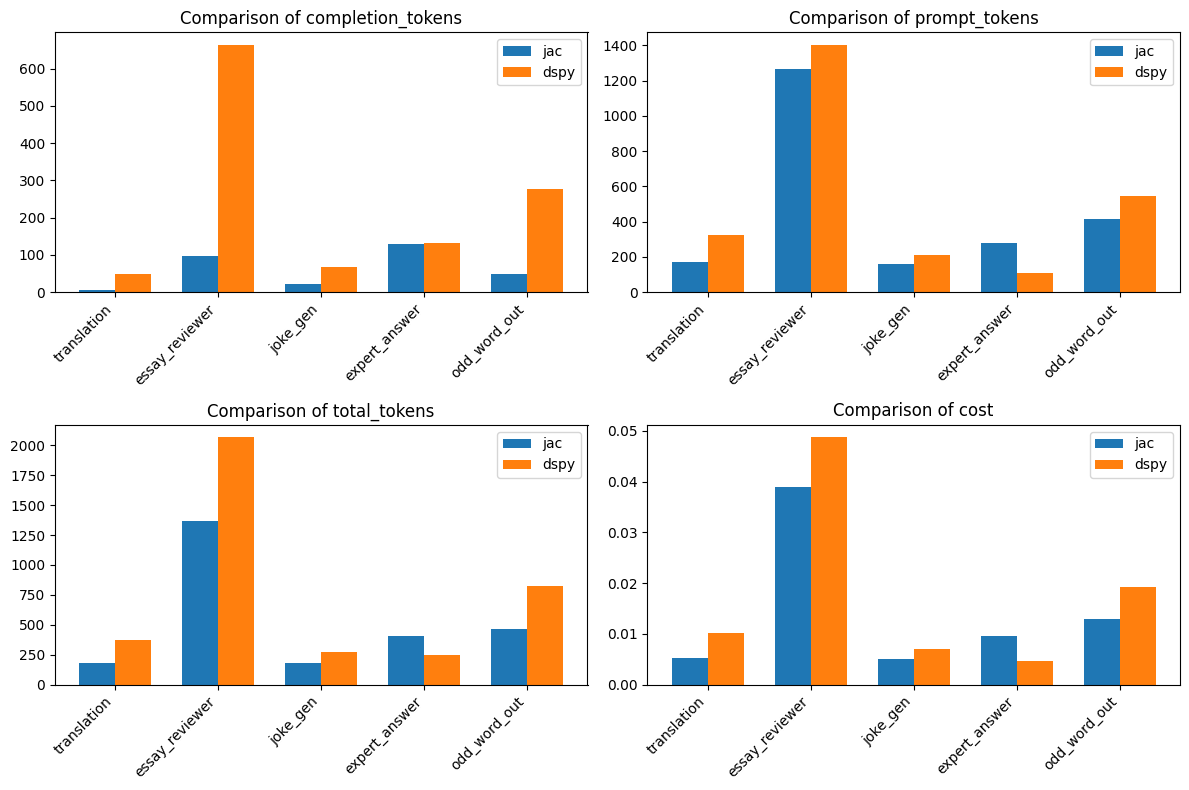

In [149]:
def plot_token_comparison(results_df, difficulty):
    problems = results_df['problem'].unique()
    criteria = ['completion_tokens', 'prompt_tokens', 'total_tokens', 'cost']

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axs = axs.flatten()

    for i, criterion in enumerate(criteria):
        jac_data = results_df[f'jac_{criterion}']
        dspy_data = results_df[f'dspy_{criterion}']

        x = np.arange(len(problems))
        width = 0.35
        axs[i].bar(x - width/2, jac_data, width, label='jac')
        axs[i].bar(x + width/2, dspy_data, width, label='dspy')

        axs[i].set_xticks(x)
        axs[i].set_xticklabels(problems, rotation=45, ha='right')
        axs[i].set_title(f'Comparison of {criterion}')
        axs[i].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'{difficulty}_token_usage.png'))
    plt.show()
    results_df.to_csv(os.path.join(RESULTS_DIR, f'{difficulty}_token_usage.csv'), index=False)

plot_token_comparison(results_df, ANALYSIS_DIFFICULTY)

## Time Taken Analysis

In [150]:
import pstats

def get_time(problem, impl):
    try:
        p_dspy = pstats.Stats(f'{JAC_RESULTS_DIR if impl=="jac" else DSPY_RESULTS_DIR}/{problem}/{impl}/profile.prof')
        total_time = p_dspy.total_tt
        print(problem, impl, total_time)
        llm_time = p_dspy.sort_stats('cumulative').stats[('/opt/conda/envs/jaclang/lib/python3.12/site-packages/openai/_utils/_utils.py', 243, 'wrapper')][3]
        return total_time, llm_time
    except Exception as e:
        print(e)
        return 0, 0

In [151]:
def get_results_df_with_time(results_df):
    results_df_with_time = results_df.copy()
    results_df_with_time['jac_runtime'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'jac')[0])
    results_df_with_time['jac_llm_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'jac')[1])
    results_df_with_time['dspy_runtime'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'dspy')[0])
    results_df_with_time['dspy_llm_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'dspy')[1])
    results_df_with_time["jac_non_llm_time"] = results_df_with_time["jac_runtime"] - results_df_with_time["jac_llm_time"]
    results_df_with_time["dspy_non_llm_time"] = results_df_with_time["dspy_runtime"] - results_df_with_time["dspy_llm_time"]
    results_df_with_time["jac_non_llm_time_percent"] = results_df_with_time["jac_non_llm_time"] / results_df_with_time["jac_runtime"]
    results_df_with_time["dspy_non_llm_time_percent"] = results_df_with_time["dspy_non_llm_time"] / results_df_with_time["dspy_runtime"]
    return results_df_with_time

In [152]:
results_df_with_time = get_results_df_with_time(results_df)
results_df_with_time

translation jac 1.5660634340000037
essay_reviewer jac 7.5381123870000035
joke_gen jac 1.3208565430000008
expert_answer jac 6.962731504999998
odd_word_out jac 4.124322325999999
translation jac 1.5660634340000037
essay_reviewer jac 7.5381123870000035
joke_gen jac 1.3208565430000008
expert_answer jac 6.962731504999998
odd_word_out jac 4.124322325999999
translation dspy 9.277904777999986
essay_reviewer dspy 30.064262994999996
joke_gen dspy 6.002984382999995
expert_answer dspy 7.456106036000001
odd_word_out dspy 15.418527959000002
translation dspy 9.277904777999986
essay_reviewer dspy 30.064262994999996
joke_gen dspy 6.002984382999995
expert_answer dspy 7.456106036000001
odd_word_out dspy 15.418527959000002


,problem,jac_completion_tokens,jac_prompt_tokens,jac_total_tokens,dspy_completion_tokens,dspy_prompt_tokens,dspy_total_tokens,jac_cost,dspy_cost,jac_runtime,jac_llm_time,dspy_runtime,dspy_llm_time,jac_non_llm_time,dspy_non_llm_time,jac_non_llm_time_percent,dspy_non_llm_time_percent
0,translation,7,171,178,50,325,375,0.00520,0.01025,1.566063,0.888217,9.277905,4.412014,0.677847,4.865891,0.432835,0.524460
1,essay_reviewer,98,1267,1365,664,1403,2067,0.03899,0.04873,7.538112,7.460460,30.064263,30.041049,0.077652,0.023214,0.010301,0.000772
2,joke_gen,21,161,182,67,210,277,0.00504,0.00697,1.320857,1.275921,6.002984,5.987982,0.044936,0.015003,0.034020,0.002499
3,expert_answer,128,277,405,133,111,244,0.00959,0.00466,6.962732,6.906805,7.456106,7.442160,0.055927,0.013946,0.008032,0.001870
4,odd_word_out,50,414,464,277,547,824,0.01292,0.01918,4.124322,4.068184,15.418528,15.397616,0.056139,0.020912,0.013612,0.001356


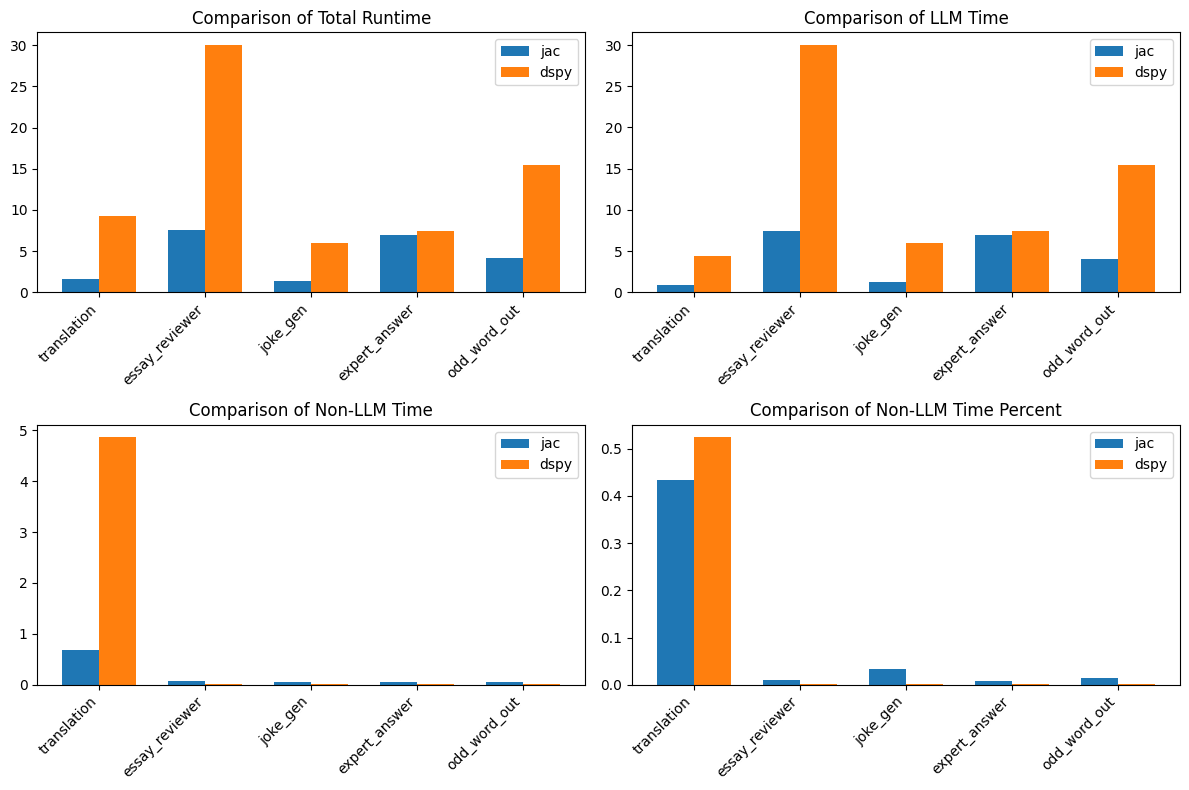

In [153]:
def plot_time_comparison(results_df_with_time, difficulty):
    problems = results_df_with_time['problem'].unique()
    criteria = ['runtime','llm_time','non_llm_time','non_llm_time_percent']
    titles = ['Total Runtime', 'LLM Time', 'Non-LLM Time', 'Non-LLM Time Percent']

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axs = axs.flatten()

    for i, criterion in enumerate(criteria):  # Truncate the criteria list
        jac_data = results_df_with_time[f'jac_{criterion}']
        dspy_data = results_df_with_time[f'dspy_{criterion}']

        x = np.arange(len(problems))
        width = 0.35
        axs[i].bar(x - width/2, jac_data, width, label='jac')
        axs[i].bar(x + width/2, dspy_data, width, label='dspy')

        axs[i].set_xticks(x)
        axs[i].set_xticklabels(problems, rotation=45, ha='right')
        axs[i].set_title(f'Comparison of {titles[i]}')
        axs[i].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'{difficulty}_runtime.png'))
    plt.show()
    results_df_with_time.to_csv(os.path.join(RESULTS_DIR, f'{difficulty}_runtime.csv'), index=False)

plot_time_comparison(results_df_with_time, ANALYSIS_DIFFICULTY)

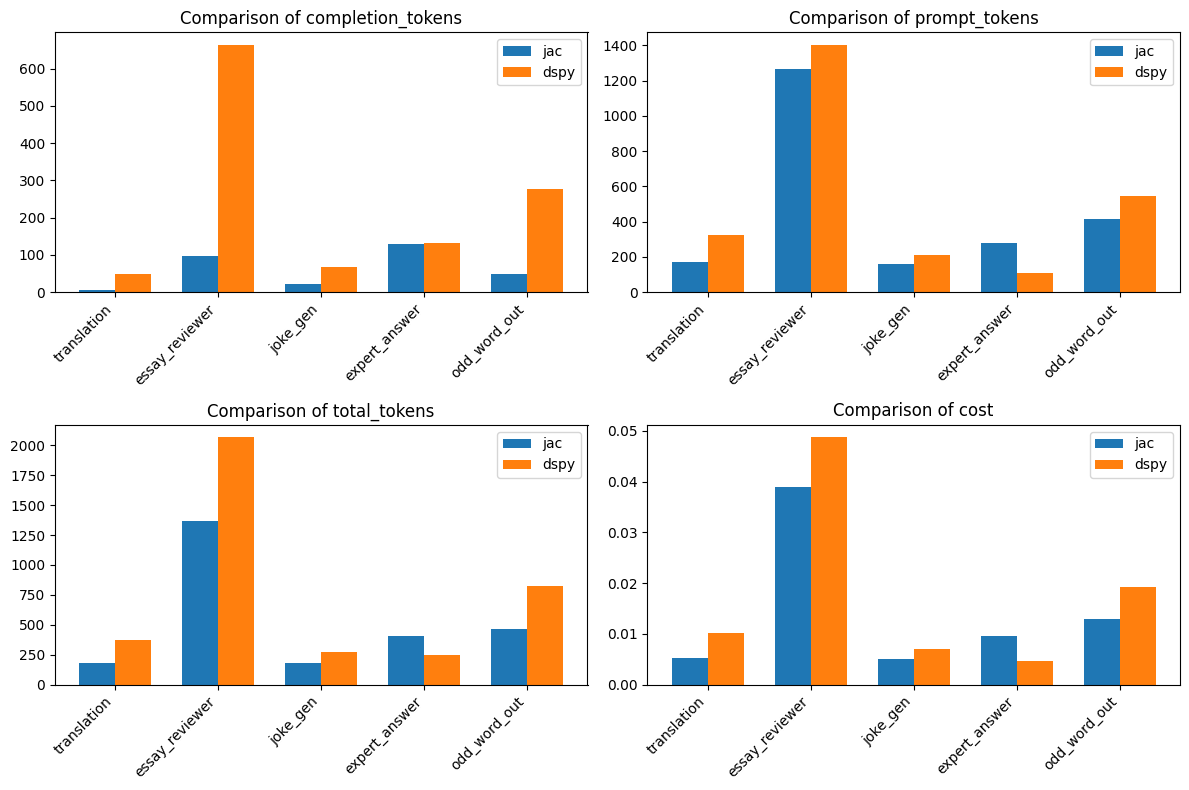

translation jac 1.5660634340000037
essay_reviewer jac 7.5381123870000035
joke_gen jac 1.3208565430000008
expert_answer jac 6.962731504999998
odd_word_out jac 4.124322325999999
translation jac 1.5660634340000037
essay_reviewer jac 7.5381123870000035
joke_gen jac 1.3208565430000008
expert_answer jac 6.962731504999998
odd_word_out jac 4.124322325999999
translation dspy 9.277904777999986
essay_reviewer dspy 30.064262994999996
joke_gen dspy 6.002984382999995
expert_answer dspy 7.456106036000001
odd_word_out dspy 15.418527959000002
translation dspy 9.277904777999986


essay_reviewer dspy 30.064262994999996
joke_gen dspy 6.002984382999995
expert_answer dspy 7.456106036000001
odd_word_out dspy 15.418527959000002


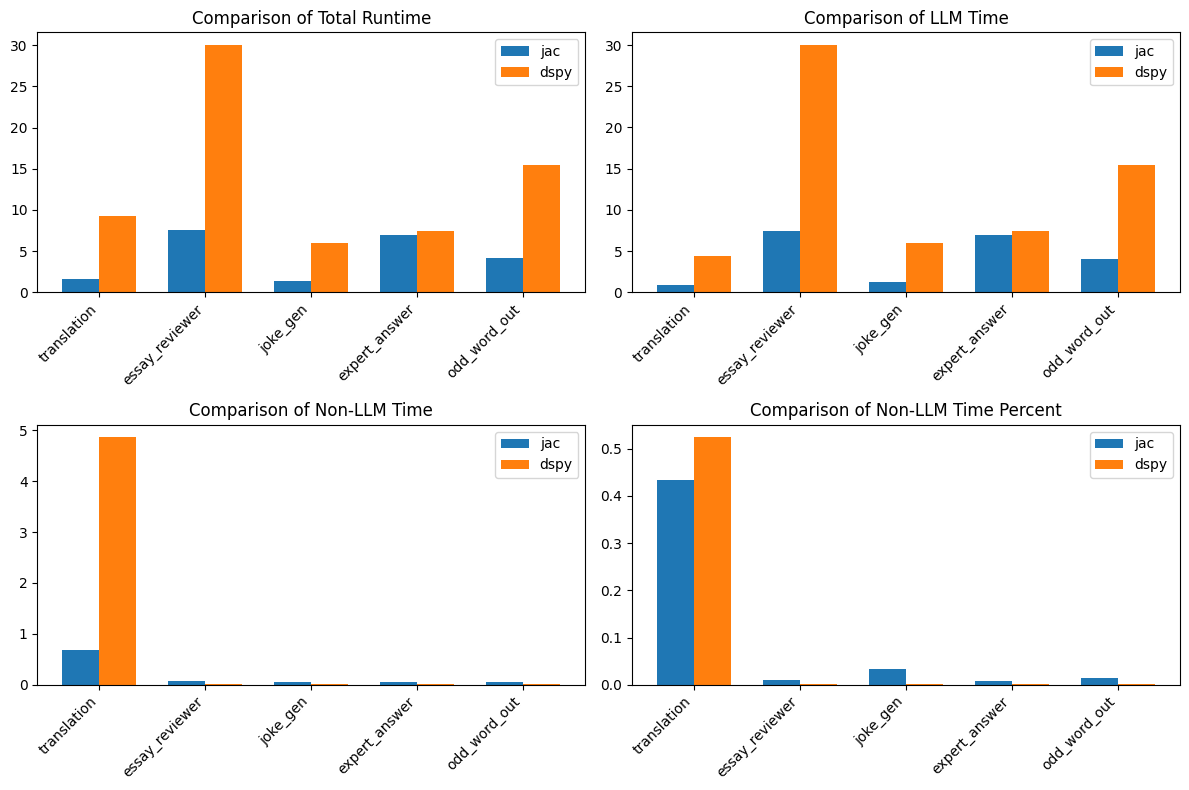

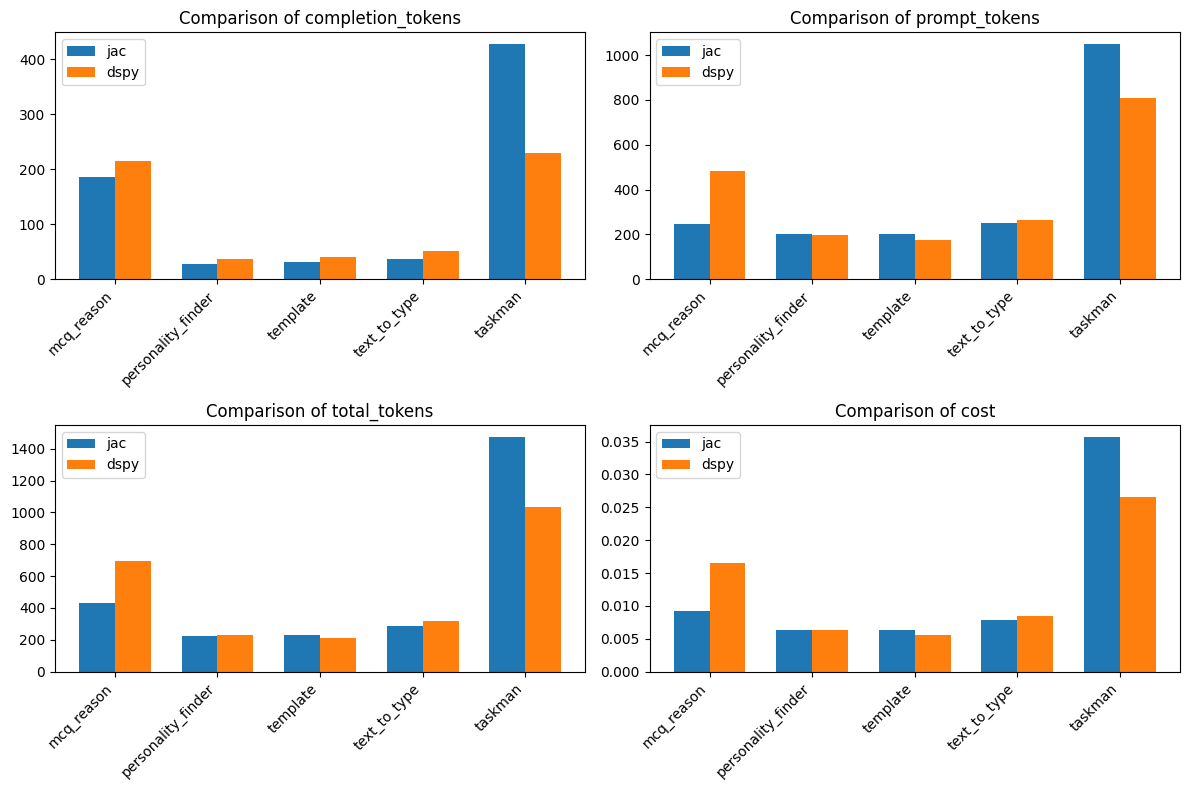

mcq_reason jac 7.717179676999999
personality_finder jac 1.9499530809999988
template jac 2.0080984230000003
text_to_type jac 2.0643339119999995
taskman jac 20.26755444599999
mcq_reason jac 7.717179676999999
personality_finder jac 1.9499530809999988
template jac 2.0080984230000003
text_to_type jac 2.0643339119999995
taskman jac 20.26755444599999
mcq_reason dspy 9.561663766999995
personality_finder dspy 2.0091067240000022
template dspy 3.4623294930000004
text_to_type dspy 3.598178481999998
taskman dspy 14.395352013000009
mcq_reason dspy 9.561663766999995
personality_finder dspy 2.0091067240000022
template dspy 3.4623294930000004
text_to_type dspy 3.598178481999998
taskman dspy 14.395352013000009


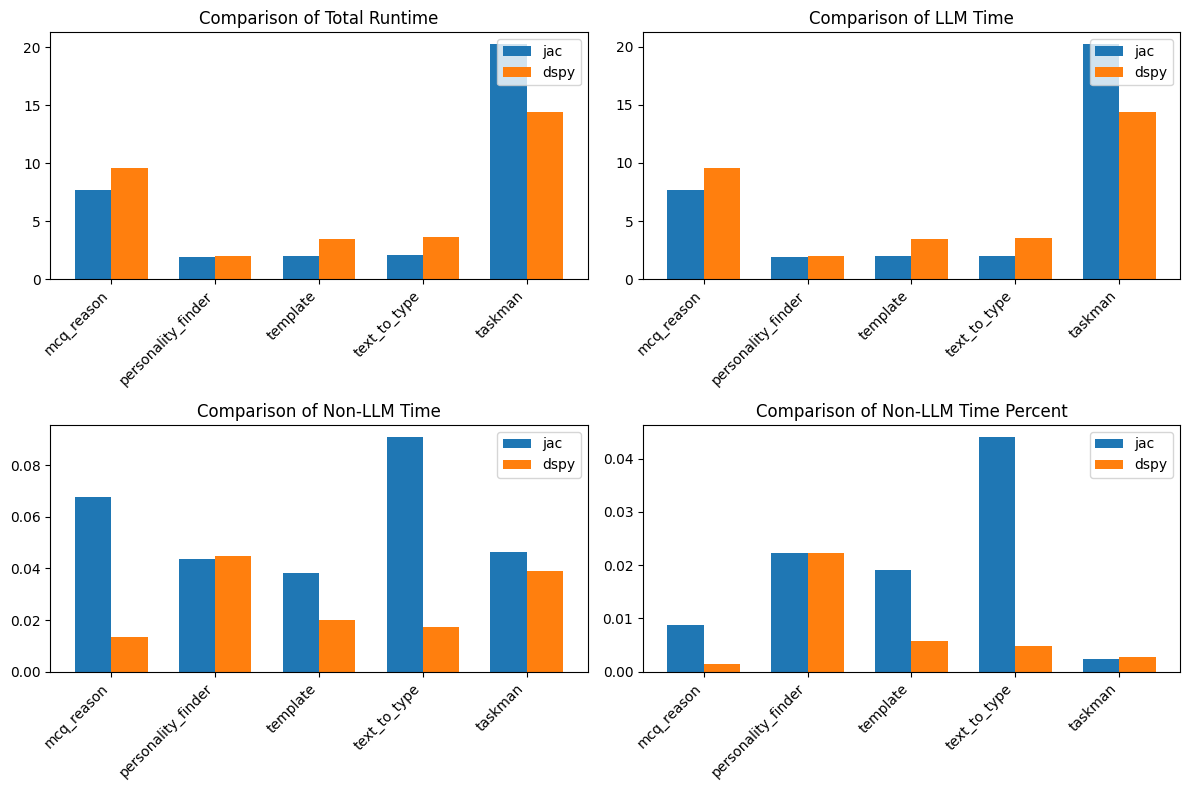

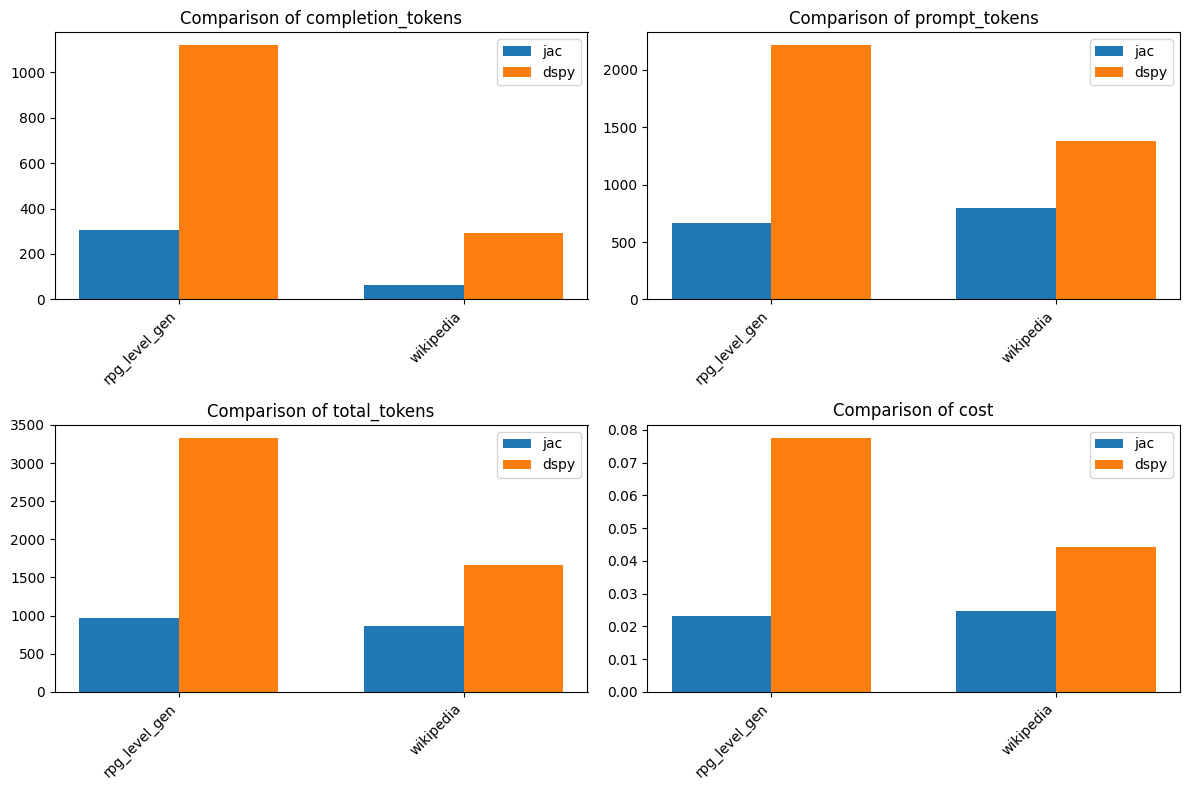

rpg_level_gen jac 17.219692580999972
wikipedia jac 8.751388325000015
rpg_level_gen jac 17.219692580999972
wikipedia jac 8.751388325000015
rpg_level_gen dspy 55.59644505400003
wikipedia dspy 20.572166717999966
rpg_level_gen dspy 55.59644505400003
wikipedia dspy 20.572166717999966


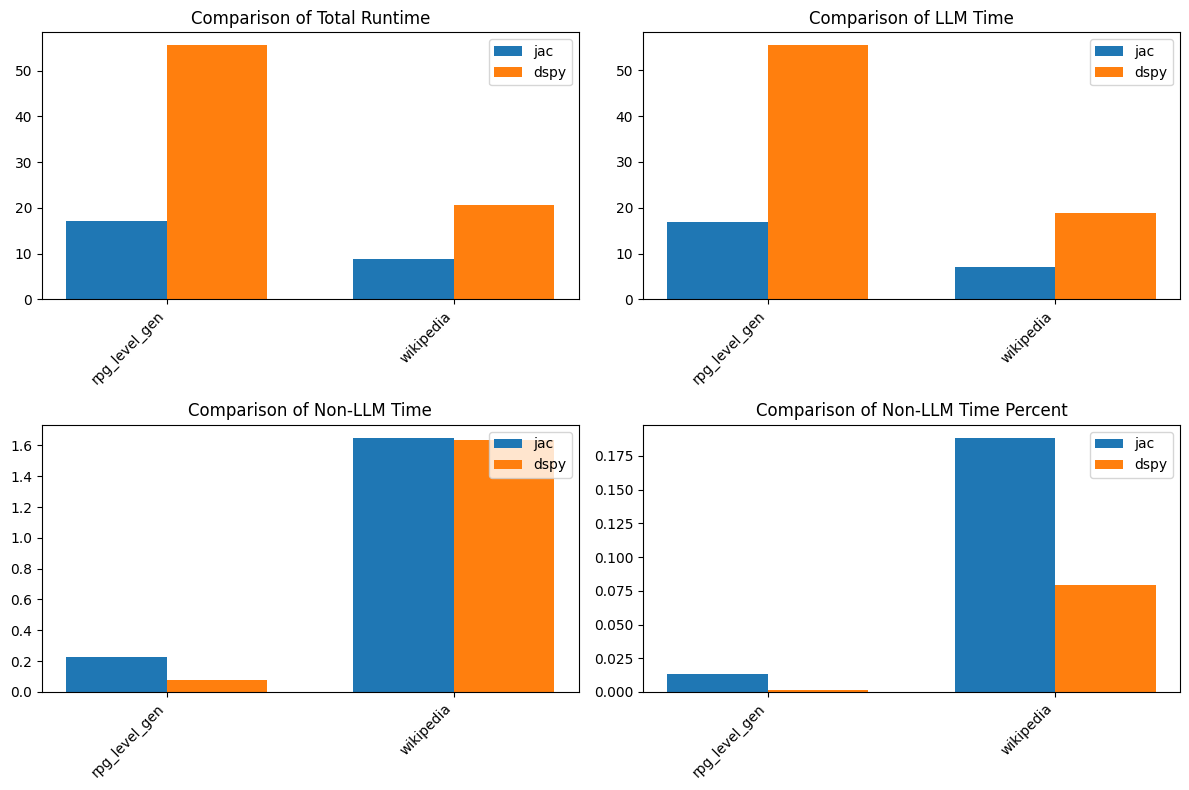

In [154]:
for difficulty in ["EASY", "MEDIUM", "HARD"]:
    _results = load_results(difficulty)
    results_df = get_results_df(_results, llm_costs)
    plot_token_comparison(results_df, difficulty)
    results_df_with_time = get_results_df_with_time(results_df)
    plot_time_comparison(results_df_with_time, difficulty)